# How to Build User Interfaces For AI Applications Using Streamlit And LangChain

## What We Will Build in This Tutorial

Most LLM providers like OpenAI and Anthropic offer user-friendly APIs for you to integrate their models into custom AI applications. But this user-friendliness comes at a cost: you will no longer be able to use familiar web interfaces like ChatGPT or Claude. Your app will be standalone, written in a bunch of scripts. 

For this reason, it is crucial to learn how to wrap your application code with a friendly user interface so that external users and stakeholders without technical know-how can interact with it. 

In this tutorial, you will learn how to build Streamlit UIs for LLM-based applications built with LangChain. The tutorial will be hands-on: we will use a real-world database of International Football history to build a chatbot that can answer questions about historical matches and international competition details. You can play around with the app using [this link](https://football-chatbot-starter.streamlit.app/) or watch it in action below:

![](images/2.gif)

Let's dive in and start building!

## Prerequisite Concepts Refresher

To build the chatbot you saw above, we will use a combination of different tools, so let's briefly go over the purposes for each.

### Streamlit

The first tool is Streamlit, which is by far the most popular framework to build web applications using only Python. It has over 35k stars and is used by the majority of Fortune 50 companies. 

Streamlit offers a rich set of built-in web components to display data and media as well as elements for taking user input. With the rise of LLMs, they now have components to display chat messages produced by both users and LLMs and a text input field for writing prompts, resembling ChatGPT's interface.

### LangChain

While LLM vendors have developer-friendly APIs, their functionality is not all-encompassing. Integrating them with existing open-source tools requires significant time and effort. 

This is why the LangChain framework was born. It brings together nearly all major LLMs under a unified syntax and provides utilities to simplify the process of building complex AI applications. LangChain offers a wide range of tools and components that enable developers to create powerful AI systems with less code and greater flexibility.

Some key features of LangChain include:
1. Seamless integration with various LLM providers
2. Built-in support for prompt engineering and management
3. Tools for memory and state management in conversational AI
4. Utilities for data loading, transformation, and vectorization
5. Components for building chains and agents for complex task automation

In the tutorial, we will use LangChain to integrate with OpenAI's GPT models, manage our conversation history, and construct our retrieval pipeline for accessing the football database.

### Graph databases, Neo4j and AuraDB

The second most popular database structure (after tabular) is graph. Graph databases are always increasing in terms of adoption for their innate ability to store interconnected information. Our Internation Football database is a perfect example. 

Graph databases are made up of nodes and the relationships between them. For example, if we consider key football terms as nodes of a graph, how they relate to each other represents node relationships. In that cases, nodes would be players, matches, teams, competitions and so on. The relationships would be: 
- Player PLAYS IN a match
- Teams PARTICIPATE IN a match
- Match is PART OF a competition

Then, nodes and relationships could have properties such as:
- Player: age, position, nationality
- Match: home team, away team, score, venue
- PLAYS IN (relationship): number of goals scored, number of minutes played

and so on. 

Neo4j is the most popular management system for such graph databases. Its query language, Cypher, is very similar to SQL but specifically desinged to traverse complex graph structures. LangChain will use Neo4j's official Python client under the hood to generate and run Cypher queries against our graph database.

Spearking of which, our databases is hosted on a cloud instance of Aura DB. Aura DB is part of Neo4j and provides a secure platform to manage graph databases on the cloud.

### Retrieval Augmented Generation

LLMs are trained on vast amounts of data but they don't have access to private databases owned by companies. For this reason, the most popular use-case of LLMs in enterprise is Retrieval Augmented Generation (RAG).

In RAG, the LLM is augmented with relevant information retrieved from a knowledge base or database before generating a response. This process typically involves the following steps:

1. Query Understanding: The system analyzes the user's query to understand its intent and key elements.

2. Information Retrieval: Based on the query analysis, relevant information is retrieved from the connected database or knowledge base.

3. Context Augmentation: The retrieved information is added to the prompt sent to the LLM, providing it with specific, up-to-date, and relevant context.

4. Response Generation: The LLM generates a response based on both its pre-trained knowledge and the additional context provided.

5. Output Refinement: The generated response may be further processed or filtered to ensure accuracy and relevance.

RAG allows LLMs to access and utilize specific, current, and proprietary information, making them more useful for specialized applications while maintaining their general language understanding capabilities. In our case, we'll use RAG to augment our LLM with information from our football database, allowing it to answer specific questions about players, matches, and competitions that it wouldn't otherwise have access to.

## Understanding the App Requirements and The Data

##  Building a Graph RAG Chatbot in LangChain

### 1. Set up the environment

Let's start by creating a new Conda environment with Python 3.9 and activate it:

```bash
$ conda create -n football_chatbot python=3.9 -y
$ conda activate football_chatbot
```

We will need to install the following libraries:


```bash
$ pip install streamlit langchain langchain-openai langchain_community neo4j
```


Now, let's create our working directory and populate its structure:


```bash
$ mkdir football_chatbot; cd football_chatbot
$ mkdir .streamlit
$ touch {.streamlit/secrets.toml,app.py}
```


We will write our application inside `app.py` while `secrets.toml` inside `.streamlit` directory will serve as our credentials file. Open it and paste the following three secrets:


```yaml
NEO4J_URI = "neo4j+s://eed9dd8f.databases.neo4j.io"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "ivbSF02UWzHeHuzBIePyOH5cQ4LdyRxLeNbWvdpPA4k"
```

These credentials give you access to the Aura DB instance that stores the football database. If you wish to create your own instance with the same data, refer to our [tutorial on Neo4j](https://www.datacamp.com/tutorial/neo4j-tutorial) that covers that exact step.

### 2. Import libraries and load the secrets

Now, let's work on the `app.py` file. At the top, import the necessary modules, packages and load the secrets using `st.secrets`:

```python
import streamlit as st
from langchain.chains import GraphCypherQAChain
from langchain_community.graphs import Neo4jGraph
from langchain_openai import ChatOpenAI
```

```python
# Load secrets
neo4j_uri = st.secrets["NEO4J_URI"]
neo4j_user = st.secrets["NEO4J_USER"]
neo4j_password = st.secrets["NEO4J_PASSWORD"]
```

Here is what each class does:
- `Neo4jGraph`: A shorthand class to connect to existing Neo4j databases and query them with Cypher.
- `GraphCypherQAChain`: an all-encompassing class to perform graph RAG on graph databases. By passing our graph loaded with `Neo4jGraph`, we can generate Cypher queries using natural language using this class. 
- `ChatOpenAI`: Gives access to the Chat Completions API of OpenAI. 

### 3. Add authentication

To prevent malicious usage and high costs, we should add an authentication that asks user's OpenAI API token. This can be achieved by adding a password form to the left sidebar using the `st.sidebar` element:

```python
# Set the app title
st.title("Football Memoirs - an AI for Hardcore Football Fans")

# Sidebar for API key input
with st.sidebar:
    openai_api_key = st.text_input("Enter your OpenAI API Key", type="password")
    st.warning("Please enter your OpenAI API key to use the chatbot.")
```

As soon as the user loads our app, they will be presented with the input field and nothing else will be shown (except app title) until they provide their key. 

### 4. Connect to Neo4j database and initialize a QA chain

After retrieving the user's OpenAI API key, we can initialize our resources: the Neo4j graph and the QA chain class:

```python
# Initialize connections and models
@st.cache_resource(show_spinner=False)
def init_resources(api_key):
    graph = Neo4jGraph(
        url=neo4j_uri,
        username=neo4j_user,
        password=neo4j_password,
        enhanced_schema=True,
    )
    graph.refresh_schema()

    chain = GraphCypherQAChain.from_llm(
        ChatOpenAI(api_key=api_key, model="gpt-4o"),
        graph=graph,
        verbose=True,
        show_intermediate_steps=True,
        allow_dangerous_requests=True,
    )
    return graph, chain
```

`init_resources()` function accepts the API key as an argument and establishes a connection with the graph database. Then, it refreshes graph schema (structure) so that the LLM can have up-to-date information about the database structure when formulating Cypher queries. Finally, it initializes the GraphCypherQAChain with the graph and OpenAI model, returning both the graph and chain objects for further use in the application.

It's worth noting the use of the `st.cache_resource()` decorator. This decorator caches the graph and chain instances, which improves performance. We don't need to create new instances every time a user loads the app, so caching them is an efficient approach.

Let's run the initializer with an API key check:

```python
# Initialize resources only if API key is provided
if openai_api_key:
    with st.spinner("Initializing resources..."):
        graph, chain = init_resources(openai_api_key)
        st.success("Resources initialized successfully!", icon="🚀")
```

### 5. Add message history to Streamlit

As soon as the resources are available, we need to enable message history by using Streamlit's session state. We also want to display an initial AI message informing the user what the bot does. 

To do so, we create a new `messages` key in `st.session_state` and set its value to a list with a single element. The element is a dictionary with two keys:
- `role`: To whom the message belongs
- `content`: The message content

```python
# Initialize message history
if "messages" not in st.session_state:
    st.session_state.messages = [
        {
            "role": "assistant",
            "content": "Hello! Ask me anything about International Football from 1872 to (the almost) present day!",
        }
    ]
```

In case there is already existing message history inside `st.session_state.messages`, we display them with `st.chat_message` and `st.markdown` components: 

```python
# Display chat history
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])
```

### 6. Display chat components

Now, we define a function, `query_graph`, that will execute the chain using a prompt provided by the user. The chain's `.invoke()` method accepts a dictionary with query-prompt key value pair and returns another dictionary as an output. We want its `result` key:

```python
def query_graph(query):
    try:
        result = chain.invoke({"query": query})["result"]
        return result
    except Exception as e:
        st.error(f"An error occurred: {str(e)}")
        return "I'm sorry, I encountered an error while processing your request."
```

Now, let's display an input field at the bottom of the page using the `st.chat_input` component:

```python
# Accept user input
if prompt := st.chat_input("Your question..."):
    st.session_state.messages.append({"role": "user", "content": prompt})
    with st.chat_message("user"):
        st.markdown(prompt)
```

As soon as the prompt is provided, we store it as a user message in message history and display it on the screen. Then, with another API key check, we run the `query_graph` function, passing the prompt:

```python
if prompt := st.chat_input("Your question..."):
    ...

    # Generate answer if API key is provided
    if openai_api_key:
        with st.spinner("Thinking..."):
            response = query_graph(prompt)

        with st.chat_message("assistant"):
            st.markdown(response)

        st.session_state.messages.append({"role": "assistant", "content": response})
    else:
        st.error("Please enter your OpenAI API key in the sidebar to use the chatbot.")
```

We add a spinner widget while the Cypher query and the final response is being generated. Then, we display the message and append it to the message history. 

That's it! The app is now ready:

![](images/1.gif)

### 7. Optimize and organize the code

The app is ready but it is written in a single file without any optimized structure. Let's revamp and make it modular:

```bash
$ cd football_chatbot
$ rm -rf .  # Start from scratch
$ mkdir .streamlit
$ touch {.streamlit/secrets.toml,.gitignore,app.py,chat_utils.py,graph_utils.py,README.MD,requirements.txt}
```

This time, our directory structure contains a few more files:

```
.
├── .git
├── .gitignore
├── .streamlit
├── README.md
├── app.py
├── chat_utils.py
├── graph_utils.py
├── requirements.txt
└── system_prompts.py
```

Now, inside `graph_utils.py`, paste the following organized code:

```python
# graph_utils.py
import streamlit as st
from langchain.chains import GraphCypherQAChain
from langchain_community.graphs import Neo4jGraph
from langchain_openai import ChatOpenAI


@st.cache_resource(show_spinner=False)
def init_resources(api_key):
    graph = Neo4jGraph(
        url=st.secrets["NEO4J_URI"],
        username=st.secrets["NEO4J_USER"],
        password=st.secrets["NEO4J_PASSWORD"],
        enhanced_schema=True,
    )
    graph.refresh_schema()

    chain = GraphCypherQAChain.from_llm(
        ChatOpenAI(api_key=api_key, model="gpt-4o"),
        graph=graph,
        verbose=True,
        show_intermediate_steps=True,
        allow_dangerous_requests=True,
    )
    return graph, chain


def query_graph(chain, query):
    result = chain.invoke({"query": query})["result"]
    return result
```

Here, the difference is in the `query_graph` function. Specifically, it doesn't have error handling and display using the `st.error` function. We will move that part to the main `app.py` file. 

Now, let's work on the `chat_utils.py` file:

```python
# chat_utils.py
import streamlit as st


def initialize_chat_history():
    if "messages" not in st.session_state:
        st.session_state.messages = [
            {
                "role": "assistant",
                "content": "Hello! Ask me anything about International Football from 1872 to (the almost) present day!",
            }
        ]

def display_chat_history():
    for message in st.session_state.messages:
        with st.chat_message(message["role"]):
            st.markdown(message["content"])
```

First, we create two functions:
- `initialize_chat_history`: Enable message history with a default message if it isn't already available.
- `display_chat_history`: Show all messages in message history

We create another function to handle prompts and answer generation:

```python
# chat_utils.py
def handle_user_input(openai_api_key, query_graph_func, chain):
    if prompt := st.chat_input("Your question..."):
        st.session_state.messages.append({"role": "user", "content": prompt})
        with st.chat_message("user"):
            st.markdown(prompt)

        if openai_api_key:
            with st.spinner("Thinking..."):
                try:
                    response = query_graph_func(chain=chain, query=prompt)
                except Exception as e:
                    st.error(f"An error occurred: {str(e)}")
                    response = "I'm sorry, I encountered an error while processing your request."

            with st.chat_message("assistant"):
                st.markdown(response)

            st.session_state.messages.append({"role": "assistant", "content": response})
        else:
            st.error(
                "Please enter your OpenAI API key in the sidebar to use the chatbot."
            )
```

The difference here is the usage of a `try-except` block around `query_graph_func` to catch and display errors. The rest of the functionality is the same. 

Finally, inside `app.py`, we put everything together:

```python
import streamlit as st
from graph_utils import init_resources, query_graph
from chat_utils import initialize_chat_history, display_chat_history, handle_user_input

st.title("Football Memoirs - an AI for Hardcore Football Fans")

# Sidebar for API key input
with st.sidebar:
    openai_api_key = st.text_input("Enter your OpenAI API Key", type="password")
    st.warning("Please enter your OpenAI API key to use the chatbot.")
```

We import the functions from other files, set the app title and add the API key input field to the left sidebar. Then, under an API key check, we initialize the resources, display chat message history and components:

```python
# Initialize resources only if API key is provided
if openai_api_key:
    with st.spinner("Initializing resources..."):
        graph, chain = init_resources(openai_api_key)
        st.success("Resources initialized successfully!", icon="🚀")

    # Initialize and display chat history
    initialize_chat_history()
    display_chat_history()

    # Handle user input
    handle_user_input(
        openai_api_key=openai_api_key, query_graph_func=query_graph, chain=chain
    )
```

Now, the app is ready for deployment!

### 8. Deploy the app to Streamlit Cloud

The easiest and most hassle-free method for deploying Streamlit apps is by using [Streamlit Cloud](share.streamlit.io). All apps hosted on Streamlit Cloud is free as long as you use the default hardware. 

But first, let's add these two lines to our `.gitignore` file so that our app secrets aren't shown on GitHub:

```.gitignore
*.toml
__pycache__/
```

Also, every (good) repository needs a README file. So, let's write ours:

```markdown
# Football Memoirs - AI for Hardcore Football Fans

This Streamlit app uses a Neo4j graph database and OpenAI's GPT-4o model to answer questions about international football history from 1872 to the present day.

## Setup

1. Clone this repository
2. Install dependencies: `pip install -r requirements.txt`
3. Set up your `.streamlit/secrets.toml` file with the following keys:
   - NEO4J_URI
   - NEO4J_USER
   - NEO4J_PASSWORD
4. Run the app: `streamlit run app.py`

## Deployment

To deploy this app on Streamlit Cloud:

1. Push your code to a GitHub repository
2. Connect your GitHub account to Streamlit Cloud
3. Create a new app in Streamlit Cloud and select your repository
4. Add your secrets in the Streamlit Cloud dashboard under the "Secrets" section
5. Deploy your app
```

Streamlit Cloud apps need `requirements.txt` file to populate app environments with dependencies. Add these to yours:

```text
streamlit
langchain
langchain-community
langchain-openai
neo4j
```

Now, we initialize git, make our first commit and push it to the remote repository you should have created for the project:

```bash
$ git init
$ git add .
$ git commit -m "Initial commit"
$ git remote add origin https://github.com/Username/repository.git
$ git push --set-upstream origin main
```

Then, sign up for [Streamlit Cloud](share.streamlit.io), visit your dashboard and click on "Create app":

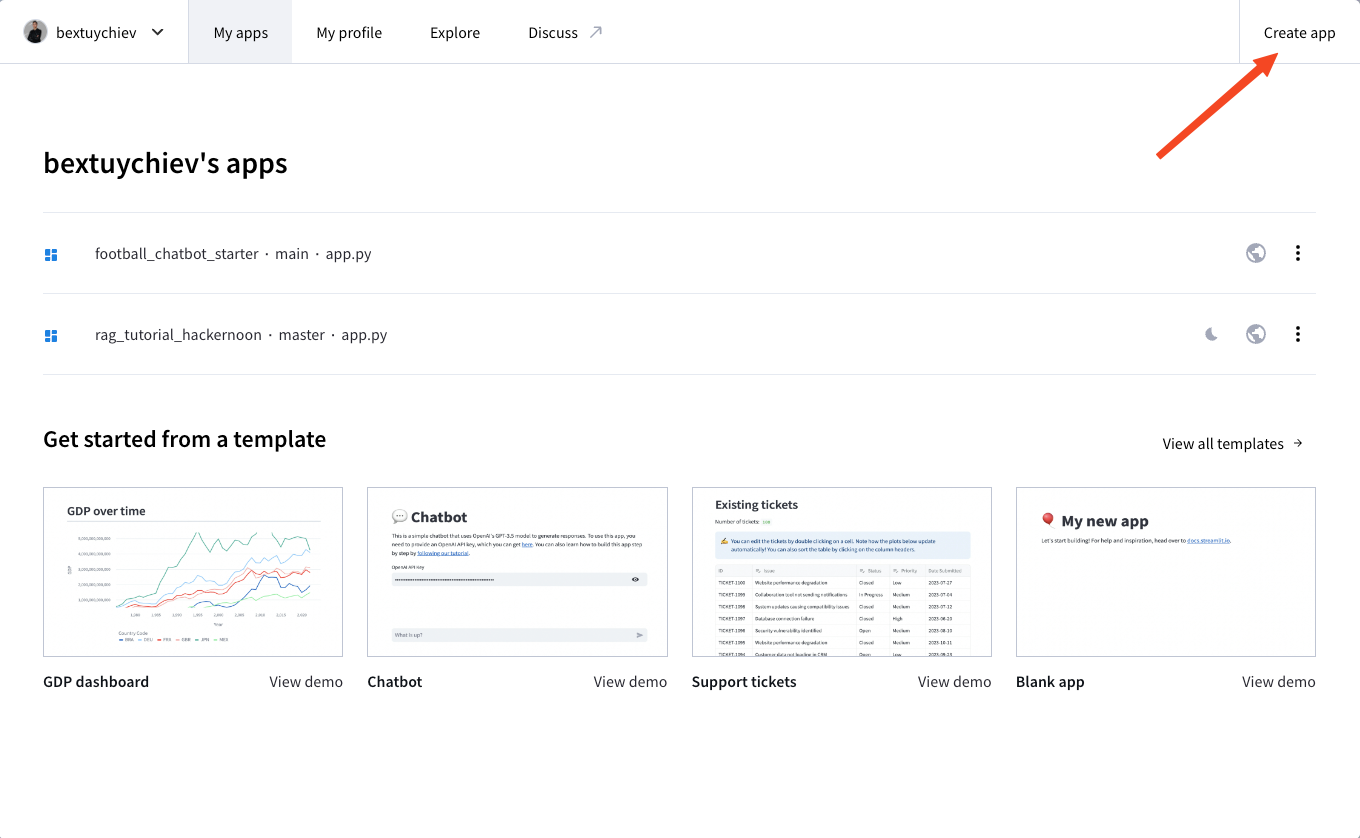

You will be presented with the following options:

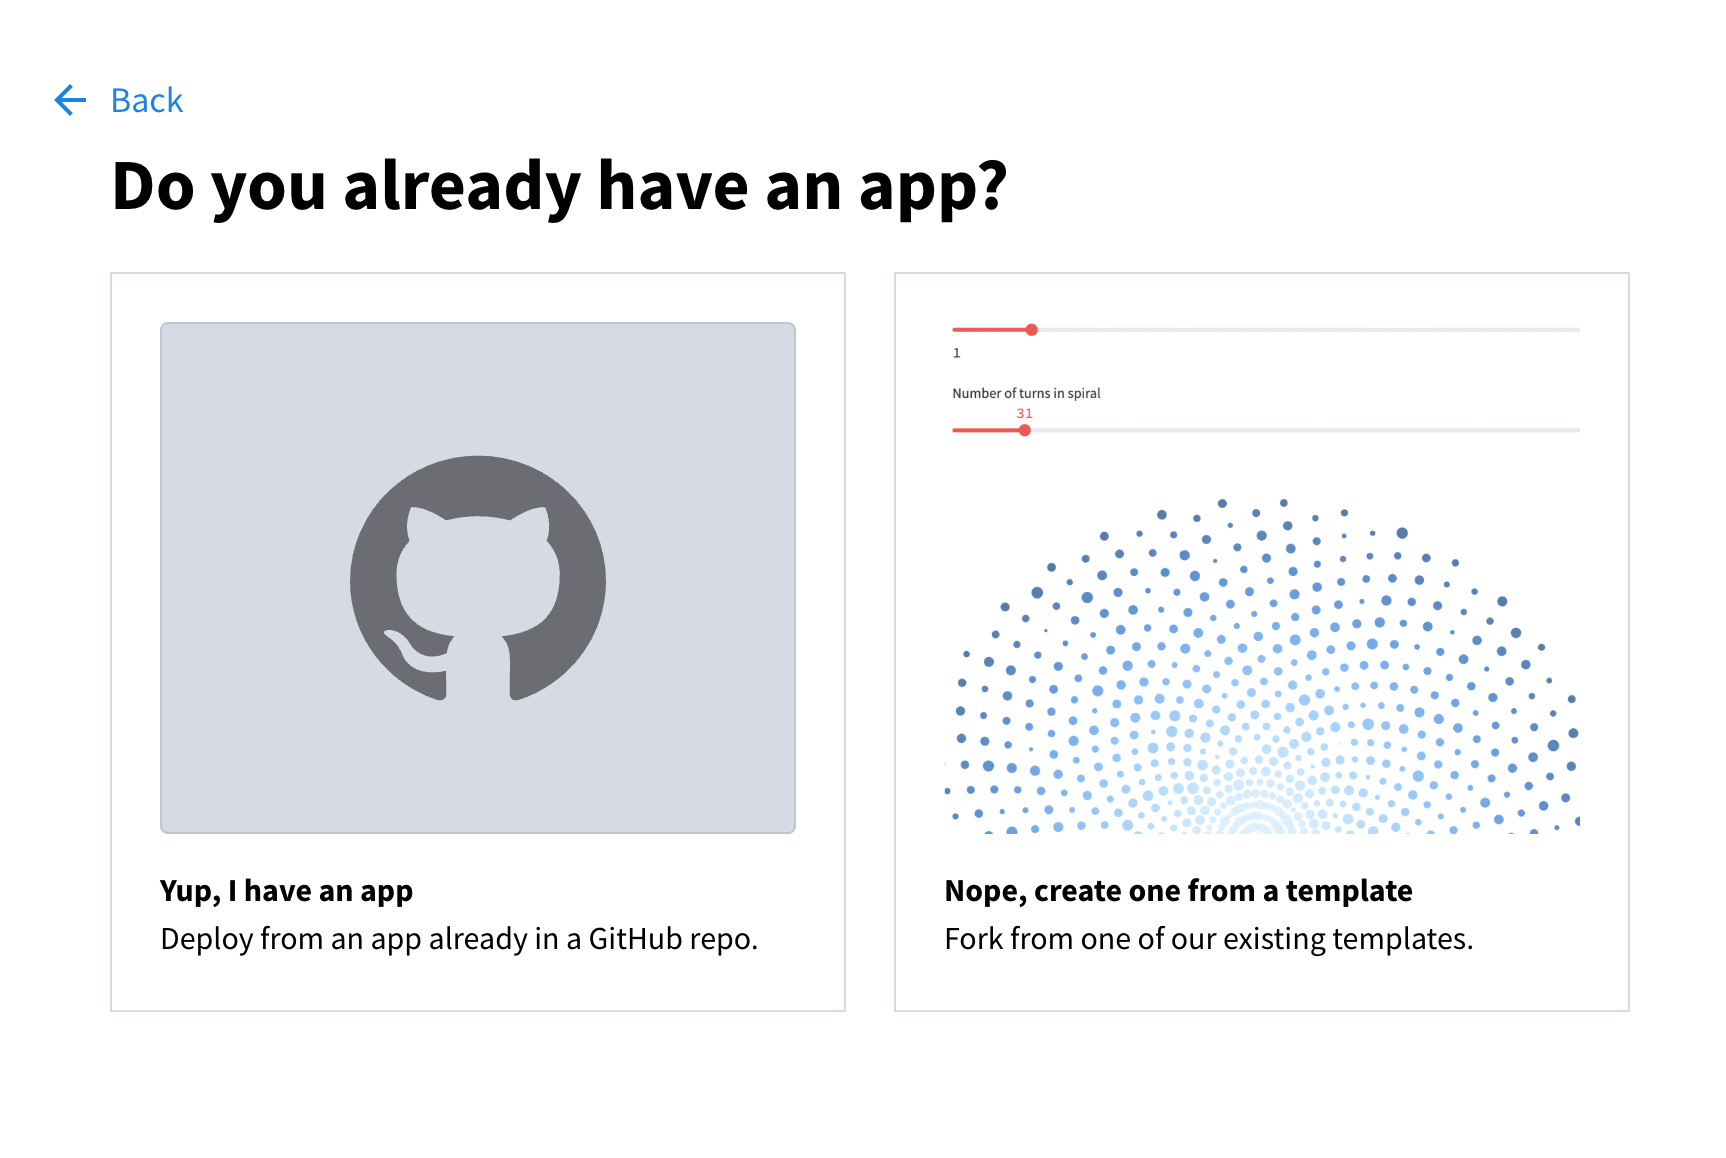

Choose the first option and fill out the fields in the next page. 

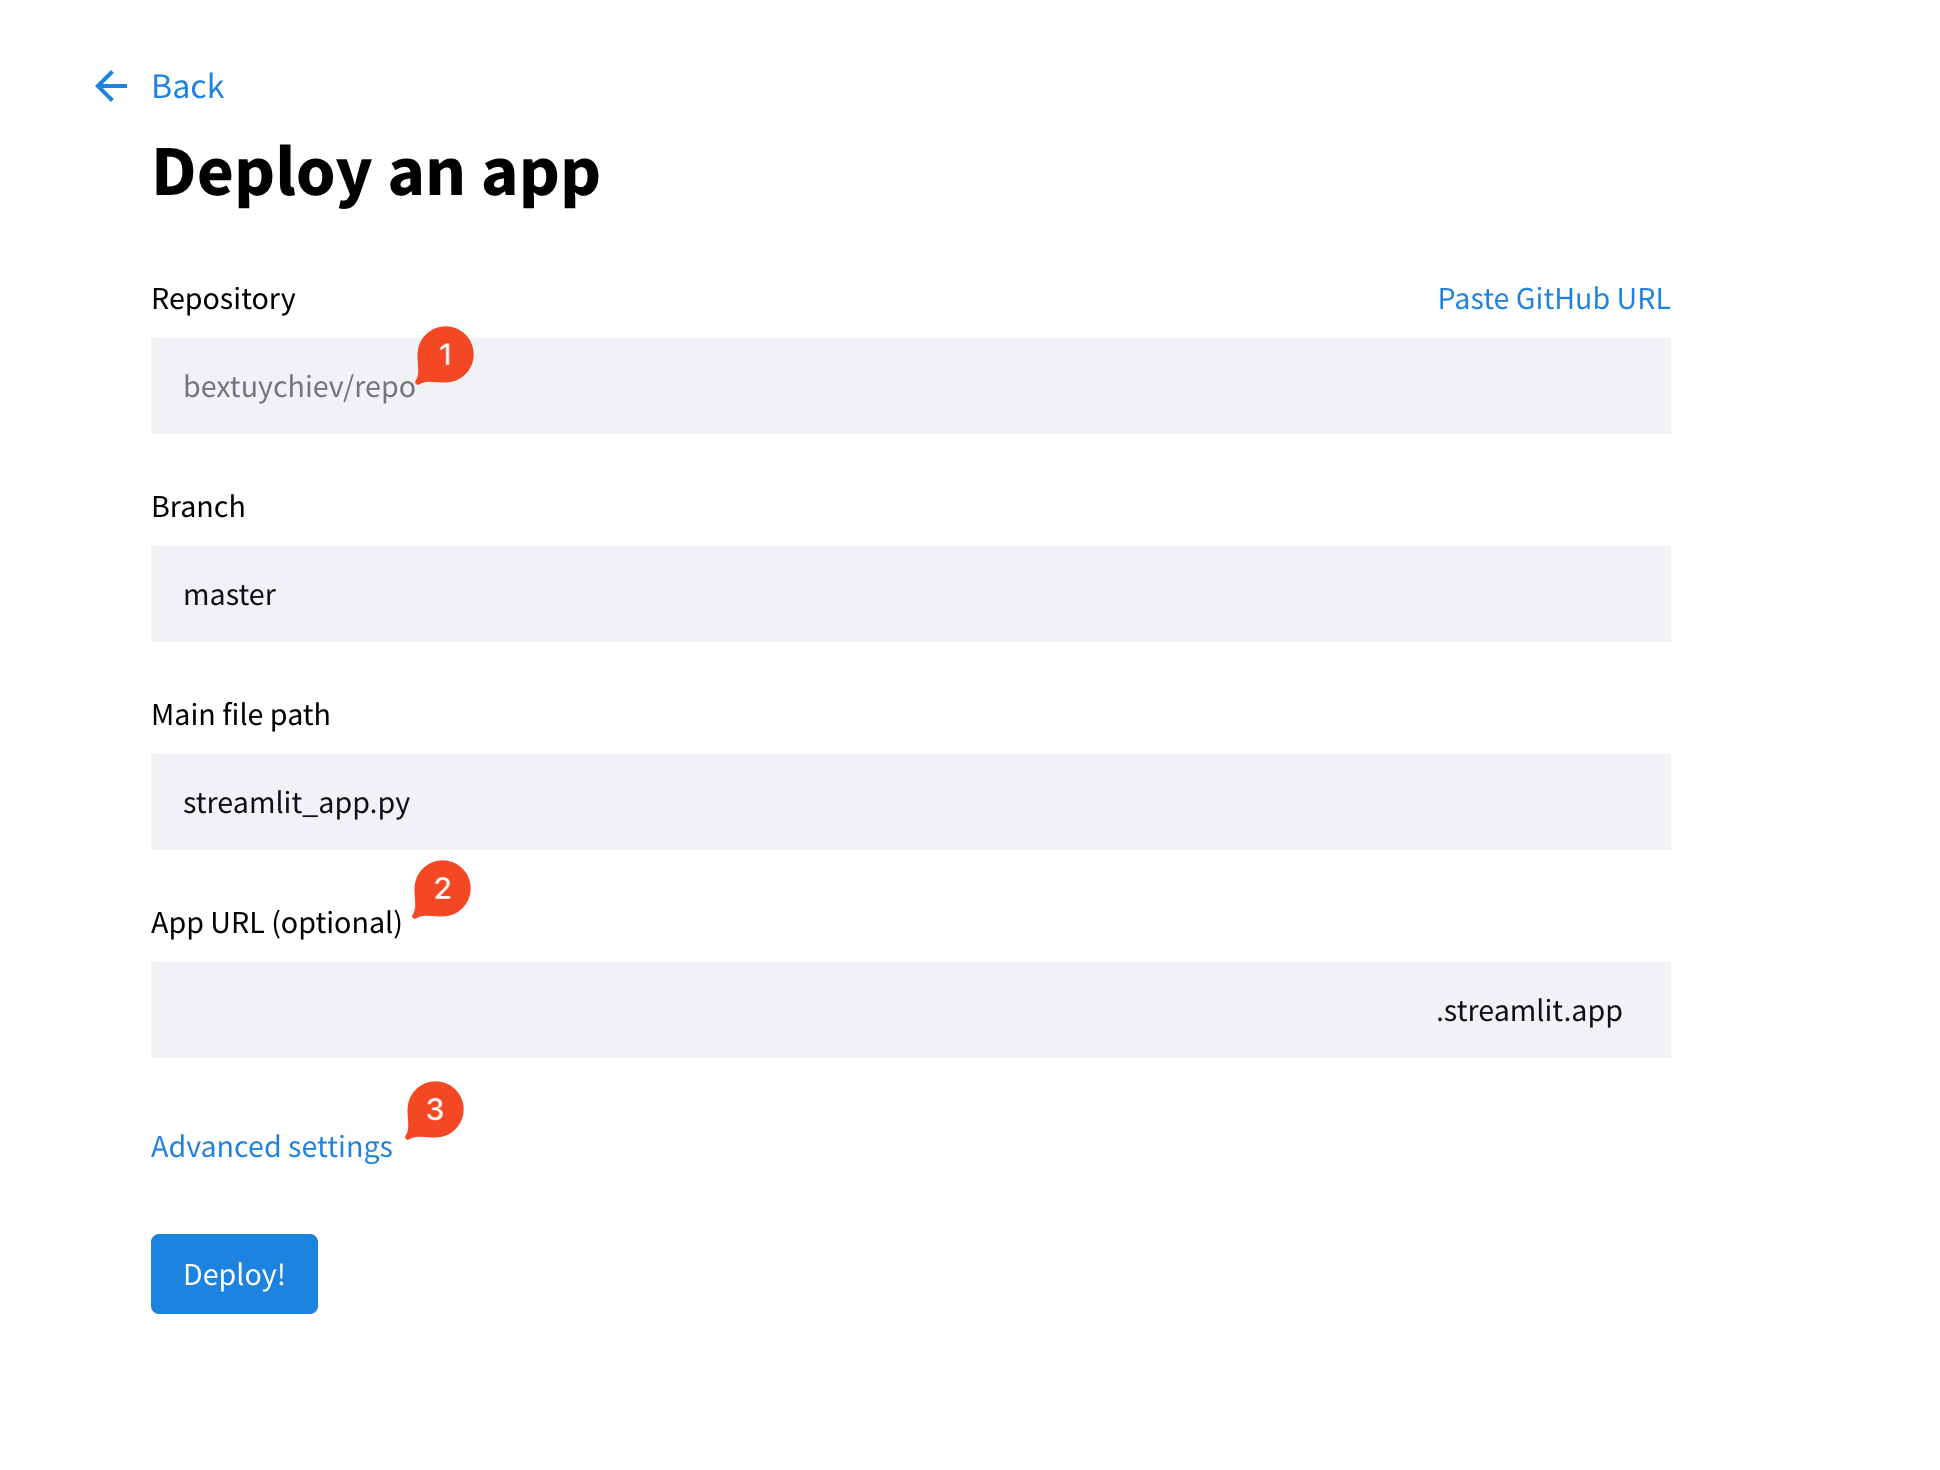

Also, expand the advanced settings which give you two fields for choosing Python version and pasting any credentials your app needs. This is where you copy/paste the contents of the local `secrets.toml` file:

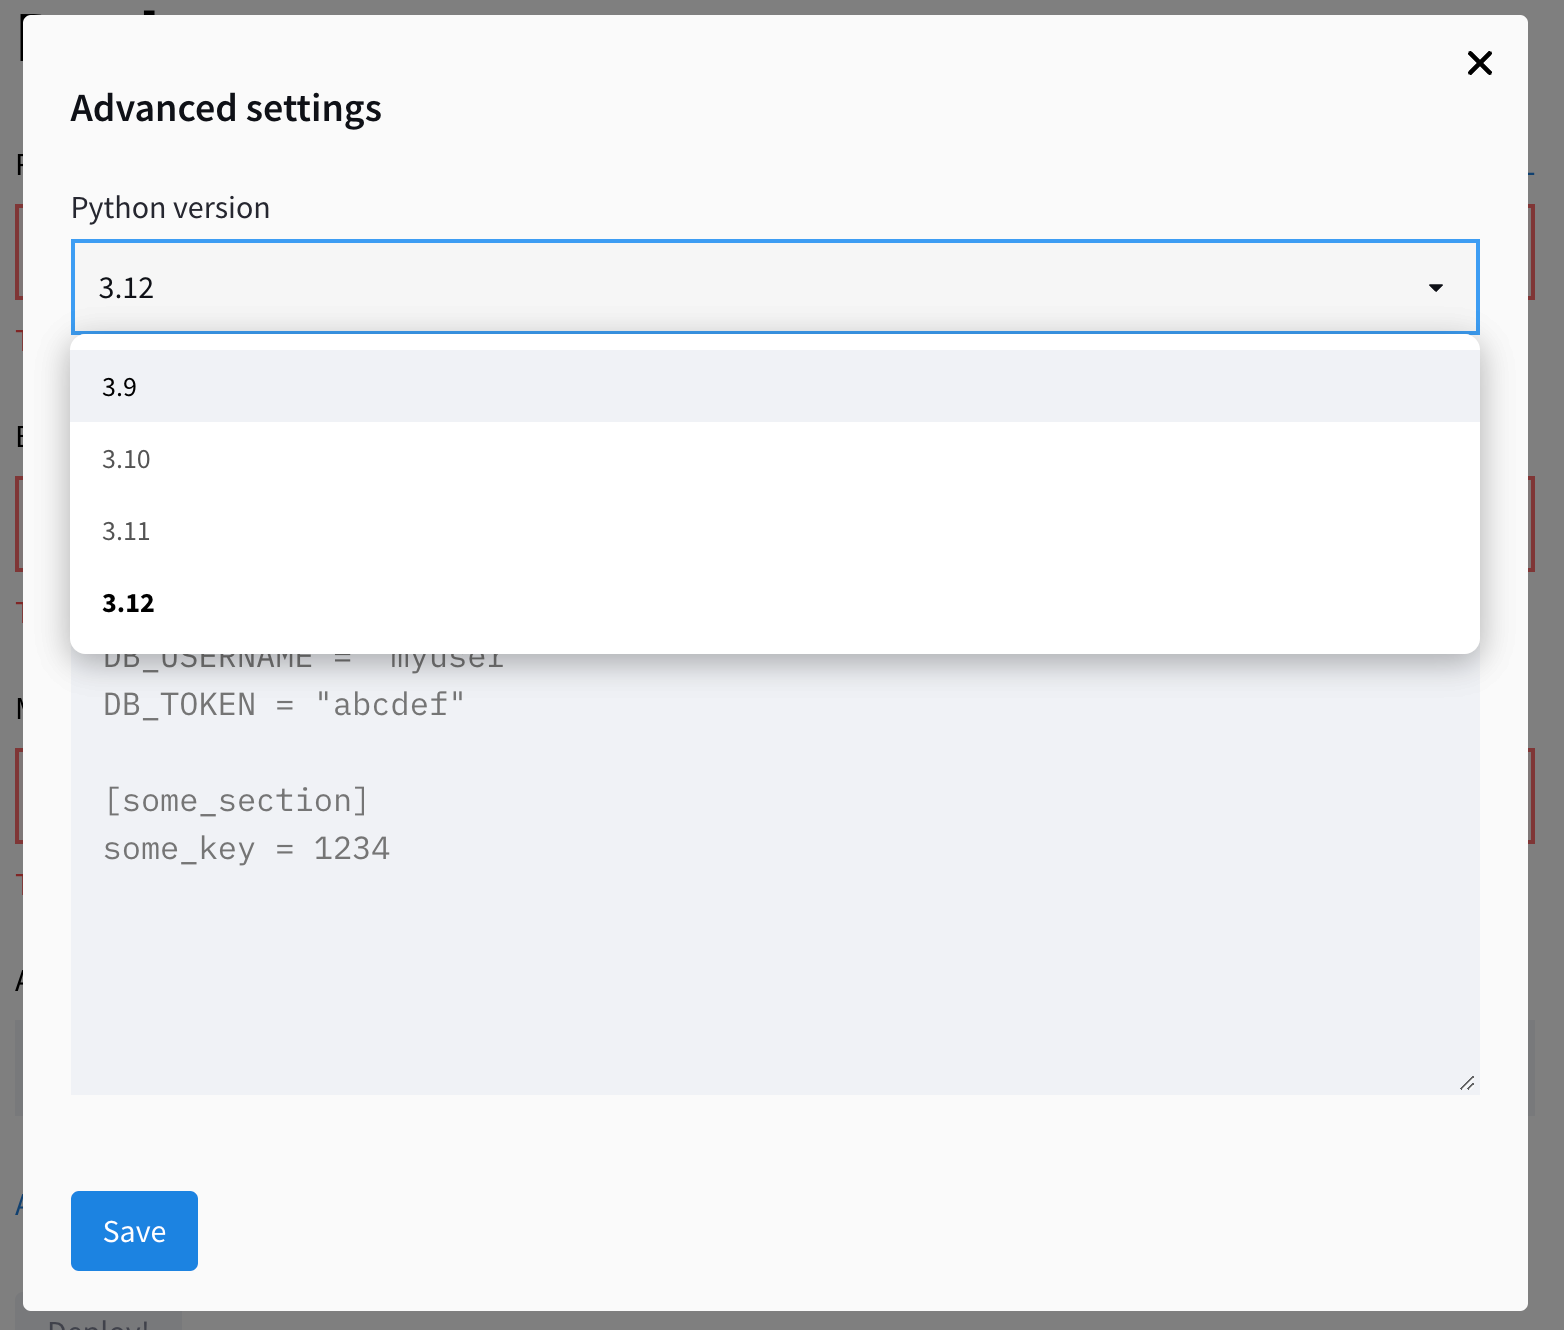

Save the secrets and click "Deploy!". The app should be operational within a couple of minutes!

## Conclusion